In [1]:
import numpy as np
import pandas as pd

In [2]:
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
from datetime import timedelta

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Settings

In [4]:
with open('settings.json', 'r') as j:
    json_data = json.load(j)

In [5]:
project_path = json_data["project_path"]

data_path = os.path.join(project_path, "data")
python_path = os.path.join(project_path, "python")


data_chunks = os.path.join(data_path,"data_chunks")
output_data_path = os.path.join(data_path, "output")

supporting_dp = os.path.join(data_path, "supporting")

role =  json_data["role"]

### Notes on where we plan train and where we plan test/validate

* Our data is shape hourly;

* We plan do predition each hour for the period of 4 weeks;

* We plan tarin data on from let say from 2013-May-01-00-00 to 2016-April-30-23-00;

* We plan to test data on 2016-May in sagemaker (4 weeks);

* We plan to reflect all calculation on 2016-June for local calculations (4 weeks);

* We start with some toy squareres probably or with reduced timeframe

* for FE there is no need to account such things as week day: [see](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html), try to do clustering based on the sape of timeseries

### Read dataset

In [6]:
pivoted_dt = pd.read_csv(os.path.join(output_data_path, "input_dataset_pivoted.csv")
                         , header=0
                         , parse_dates=['Time'])

In [7]:
pivoted_dt.head()

,Time,1075,1076,1077,1125,1126,1127,1128,1129,1130,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
0,2011-01-01 00:00:00,33.0,68.0,23.0,39.0,156.0,261.0,287.0,354.0,371.0,...,12.0,0.0,4.0,20.0,20.0,11.0,1.0,47.0,1.0,19.0
1,2011-01-01 01:00:00,42.0,68.0,31.0,59.0,182.0,256.0,245.0,264.0,252.0,...,10.0,0.0,4.0,22.0,13.0,10.0,5.0,34.0,4.0,18.0
2,2011-01-01 02:00:00,40.0,59.0,18.0,62.0,170.0,225.0,228.0,255.0,235.0,...,14.0,0.0,4.0,1.0,1.0,0.0,2.0,11.0,2.0,0.0
3,2011-01-01 03:00:00,35.0,52.0,18.0,47.0,129.0,216.0,208.0,213.0,183.0,...,7.0,0.0,4.0,2.0,1.0,0.0,0.0,12.0,0.0,0.0
4,2011-01-01 04:00:00,17.0,29.0,9.0,31.0,83.0,149.0,185.0,173.0,142.0,...,13.0,0.0,3.0,1.0,2.0,0.0,0.0,4.0,1.0,0.0


In [8]:
pivoted_dt.set_index("Time", drop=True, inplace=True)
pivoted_dt.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
Time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,33.0,68.0,23.0,39.0,156.0,261.0,287.0,354.0,371.0,128.0,...,12.0,0.0,4.0,20.0,20.0,11.0,1.0,47.0,1.0,19.0
2011-01-01 01:00:00,42.0,68.0,31.0,59.0,182.0,256.0,245.0,264.0,252.0,116.0,...,10.0,0.0,4.0,22.0,13.0,10.0,5.0,34.0,4.0,18.0
2011-01-01 02:00:00,40.0,59.0,18.0,62.0,170.0,225.0,228.0,255.0,235.0,99.0,...,14.0,0.0,4.0,1.0,1.0,0.0,2.0,11.0,2.0,0.0
2011-01-01 03:00:00,35.0,52.0,18.0,47.0,129.0,216.0,208.0,213.0,183.0,85.0,...,7.0,0.0,4.0,2.0,1.0,0.0,0.0,12.0,0.0,0.0
2011-01-01 04:00:00,17.0,29.0,9.0,31.0,83.0,149.0,185.0,173.0,142.0,63.0,...,13.0,0.0,3.0,1.0,2.0,0.0,0.0,4.0,1.0,0.0


## Simple Sagemaker Model

### Do transformations for Sagemaker

as a basis that link was taken: [Elictricity Consumption](https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb)

In [9]:
pivoted_dt.shape

(48192, 102)

In [10]:
num_timeseries = pivoted_dt.shape[1]
data_kw = pivoted_dt.resample('1H').sum()
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:,i], trim='f'))

In [11]:
data_kw.shape

(48192, 102)

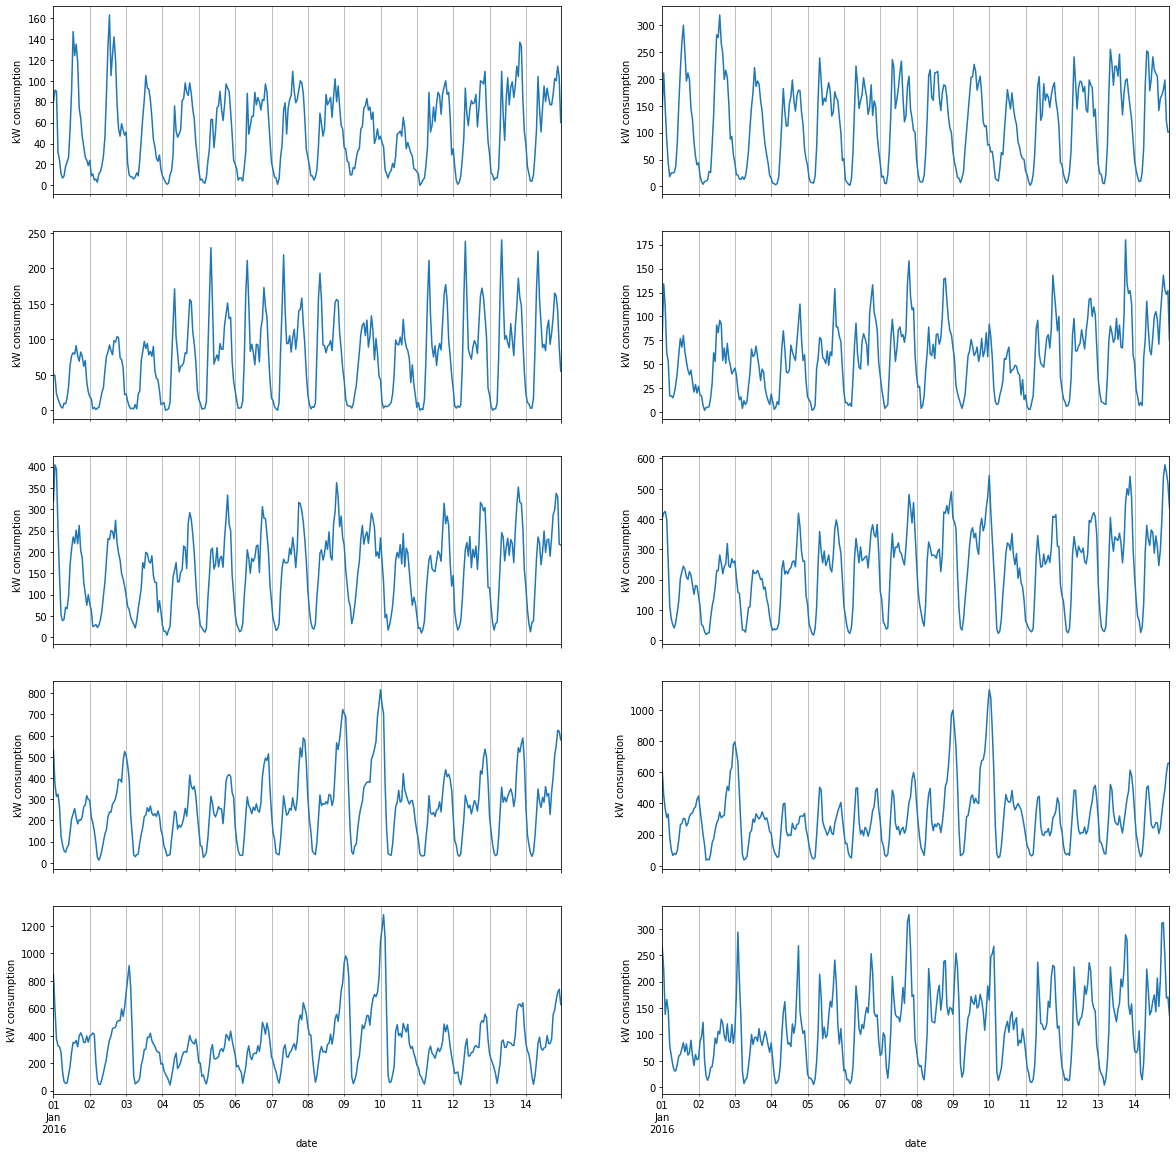

In [12]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2016-01-01":"2016-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")   
    axx[i].grid(which='minor', axis='x')

#### Train test split

In [13]:
# we use 1 hour frequency for the time series
freq = '1H'

# we predict for 7 days
prediction_length = 7 * 24

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 24

In [14]:
#start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)
start_dataset = pd.Timestamp("2016-04-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2016-05-02 00:00:00", freq=freq)

In [15]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - timedelta(hours=25)].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]
print(len(training_data))

102


In [16]:
for ts in timeseries[:1]:
    tmp = ts[start_dataset:end_training - timedelta(hours=25)]
    print(tmp)
    print(tmp[0])
    print(tmp[-1])

Time
2016-04-01 00:00:00     46.0
2016-04-01 01:00:00     25.0
2016-04-01 02:00:00     12.0
2016-04-01 03:00:00      8.0
2016-04-01 04:00:00      9.0
2016-04-01 05:00:00      7.0
2016-04-01 06:00:00     16.0
2016-04-01 07:00:00     43.0
2016-04-01 08:00:00     70.0
2016-04-01 09:00:00     59.0
2016-04-01 10:00:00     72.0
2016-04-01 11:00:00     86.0
2016-04-01 12:00:00    110.0
2016-04-01 13:00:00    104.0
2016-04-01 14:00:00     93.0
2016-04-01 15:00:00    111.0
2016-04-01 16:00:00     83.0
2016-04-01 17:00:00    110.0
2016-04-01 18:00:00    133.0
2016-04-01 19:00:00    116.0
2016-04-01 20:00:00     80.0
2016-04-01 21:00:00     85.0
2016-04-01 22:00:00     92.0
2016-04-01 23:00:00    107.0
2016-04-02 00:00:00     49.0
2016-04-02 01:00:00     29.0
2016-04-02 02:00:00     29.0
2016-04-02 03:00:00     10.0
2016-04-02 04:00:00      5.0
2016-04-02 05:00:00      4.0
                       ...  
2016-04-29 18:00:00    133.0
2016-04-29 19:00:00    114.0
2016-04-29 20:00:00    100.0
2016-04-2

In [17]:
for ts in timeseries:
    tmp=ts[start_dataset:end_training - timedelta(hours=25)].tolist() 
    print(len(tmp))

720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720


In [18]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + timedelta(hours=k * prediction_length-k)].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]
print(len(test_data))

408


In [19]:
for k in range(1, num_test_windows + 1):
    for ts in timeseries[:1]:
        print(end_training + timedelta(days=k * 7))
        print(ts[start_dataset:end_training + timedelta(hours=k * prediction_length-k)])
        #print(len(ts[start_dataset:end_training + timedelta(days=k * prediction_length)]))

2016-05-09 00:00:00
Time
2016-04-01 00:00:00     46.0
2016-04-01 01:00:00     25.0
2016-04-01 02:00:00     12.0
2016-04-01 03:00:00      8.0
2016-04-01 04:00:00      9.0
2016-04-01 05:00:00      7.0
2016-04-01 06:00:00     16.0
2016-04-01 07:00:00     43.0
2016-04-01 08:00:00     70.0
2016-04-01 09:00:00     59.0
2016-04-01 10:00:00     72.0
2016-04-01 11:00:00     86.0
2016-04-01 12:00:00    110.0
2016-04-01 13:00:00    104.0
2016-04-01 14:00:00     93.0
2016-04-01 15:00:00    111.0
2016-04-01 16:00:00     83.0
2016-04-01 17:00:00    110.0
2016-04-01 18:00:00    133.0
2016-04-01 19:00:00    116.0
2016-04-01 20:00:00     80.0
2016-04-01 21:00:00     85.0
2016-04-01 22:00:00     92.0
2016-04-01 23:00:00    107.0
2016-04-02 00:00:00     49.0
2016-04-02 01:00:00     29.0
2016-04-02 02:00:00     29.0
2016-04-02 03:00:00     10.0
2016-04-02 04:00:00      5.0
2016-04-02 05:00:00      4.0
                       ...  
2016-05-07 18:00:00     95.0
2016-05-07 19:00:00    109.0
2016-05-07 20:00:0

#### Data to file

In [20]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [21]:
%%time
write_dicts_to_file(os.path.join(output_data_path,"train.json"), training_data)
write_dicts_to_file(os.path.join(output_data_path,"test.json"), test_data)

Wall time: 145 ms


### Start working with sagemaker: load data to S3

In [22]:
import boto3
import s3fs
import sagemaker

In [23]:
sagemaker_session = sagemaker.Session()

In [24]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-YT-simple-notebook'    # prefix used for all data stored within the bucket

In [25]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [26]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [27]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [28]:
copy_to_s3(os.path.join(output_data_path,"train.json"), s3_data_path + "/train/train.json", override=True)
copy_to_s3(os.path.join(output_data_path,"test.json"), s3_data_path + "/test/test.json", override=True)

Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-676236127588/deepar-YT-simple-notebook/data/train/train.json
Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-676236127588/deepar-YT-simple-notebook/data/test/test.json


In [29]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2016-04-01 00:00:00", "target": [46.0, 25.0, 12.0, 8.0, 9.0, 7.0, 16.0, 43.0, 70.0, 59.0,...


### Start working with sagemaker: set training job

In [30]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-YT-simple-notebook',
    output_path=s3_output_path
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [31]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [32]:
estimator.set_hyperparameters(**hyperparameters)

In [33]:
#%%time
data_channels = {
    "train": "{}/train/train.json".format(s3_data_path),
    "test": "{}/test/test.json".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

2020-12-05 19:11:44 Starting - Starting the training job...
2020-12-05 19:11:45 Starting - Launching requested ML instances......
2020-12-05 19:13:12 Starting - Preparing the instances for training...
2020-12-05 19:14:02 Downloading - Downloading input data...
2020-12-05 19:14:36 Training - Downloading the training image..Arguments: train
[12/05/2020 19:14:54 INFO 140629789808448] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[12/05/2020 19:14:54 I

[12/05/2020 19:15:23 INFO 140629789808448] Epoch[5] Batch[5] avg_epoch_loss=4.231206
[12/05/2020 19:15:23 INFO 140629789808448] #quality_metric: host=algo-1, epoch=5, batch=5 train loss <loss>=4.23120609919
[12/05/2020 19:15:23 INFO 140629789808448] Epoch[5] Batch [5]#011Speed: 155.53 samples/sec#011loss=4.231206
[12/05/2020 19:15:25 INFO 140629789808448] processed a total of 622 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4378.865957260132, "sum": 4378.865957260132, "min": 4378.865957260132}}, "EndTime": 1607195725.25883, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195720.879404}

[12/05/2020 19:15:25 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=142.040914053 records/second
[12/05/2020 19:15:25 INFO 140629789808448] #progress_metric: host=algo-1, completed 1 % of epochs
[12/05/2020 19:15:25 INFO 140629789808448] #quality_metric: host=algo-1, epoch=5, train loss <loss>=4.16046912

[12/05/2020 19:15:49 INFO 140629789808448] Epoch[11] Batch[0] avg_epoch_loss=3.952876
[12/05/2020 19:15:49 INFO 140629789808448] #quality_metric: host=algo-1, epoch=11, batch=0 train loss <loss>=3.95287561417
[12/05/2020 19:15:51 INFO 140629789808448] Epoch[11] Batch[5] avg_epoch_loss=3.946895
[12/05/2020 19:15:51 INFO 140629789808448] #quality_metric: host=algo-1, epoch=11, batch=5 train loss <loss>=3.9468947649
[12/05/2020 19:15:51 INFO 140629789808448] Epoch[11] Batch [5]#011Speed: 156.81 samples/sec#011loss=3.946895
[12/05/2020 19:15:53 INFO 140629789808448] Epoch[11] Batch[10] avg_epoch_loss=3.762543
[12/05/2020 19:15:53 INFO 140629789808448] #quality_metric: host=algo-1, epoch=11, batch=10 train loss <loss>=3.54132013321
[12/05/2020 19:15:53 INFO 140629789808448] Epoch[11] Batch [10]#011Speed: 153.87 samples/sec#011loss=3.541320
[12/05/2020 19:15:53 INFO 140629789808448] processed a total of 648 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4748.725175857544, 

[12/05/2020 19:16:21 INFO 140629789808448] processed a total of 614 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4304.861068725586, "sum": 4304.861068725586, "min": 4304.861068725586}}, "EndTime": 1607195781.167751, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195776.862809}

[12/05/2020 19:16:21 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=142.624718329 records/second
[12/05/2020 19:16:21 INFO 140629789808448] #progress_metric: host=algo-1, completed 4 % of epochs
[12/05/2020 19:16:21 INFO 140629789808448] #quality_metric: host=algo-1, epoch=17, train loss <loss>=3.73258731365
[12/05/2020 19:16:21 INFO 140629789808448] loss did not improve
[12/05/2020 19:16:21 INFO 140629789808448] Epoch[18] Batch[0] avg_epoch_loss=3.744789
[12/05/2020 19:16:21 INFO 140629789808448] #quality_metric: host=algo-1, epoch=18, batch=0 train loss <loss>=3.74478912354
[12/05/2020 19:16:23 INFO 1406297898

[12/05/2020 19:16:46 INFO 140629789808448] Epoch[23] Batch[5] avg_epoch_loss=3.699487
[12/05/2020 19:16:46 INFO 140629789808448] #quality_metric: host=algo-1, epoch=23, batch=5 train loss <loss>=3.69948716958
[12/05/2020 19:16:46 INFO 140629789808448] Epoch[23] Batch [5]#011Speed: 155.99 samples/sec#011loss=3.699487
[12/05/2020 19:16:48 INFO 140629789808448] Epoch[23] Batch[10] avg_epoch_loss=3.660907
[12/05/2020 19:16:48 INFO 140629789808448] #quality_metric: host=algo-1, epoch=23, batch=10 train loss <loss>=3.61461186409
[12/05/2020 19:16:48 INFO 140629789808448] Epoch[23] Batch [10]#011Speed: 153.79 samples/sec#011loss=3.614612
[12/05/2020 19:16:48 INFO 140629789808448] processed a total of 692 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4757.985830307007, "sum": 4757.985830307007, "min": 4757.985830307007}}, "EndTime": 1607195808.959817, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195804.201279}

[12/0

[12/05/2020 19:17:13 INFO 140629789808448] Epoch[29] Batch[0] avg_epoch_loss=3.598850
[12/05/2020 19:17:13 INFO 140629789808448] #quality_metric: host=algo-1, epoch=29, batch=0 train loss <loss>=3.59884977341
[12/05/2020 19:17:15 INFO 140629789808448] Epoch[29] Batch[5] avg_epoch_loss=3.570033
[12/05/2020 19:17:15 INFO 140629789808448] #quality_metric: host=algo-1, epoch=29, batch=5 train loss <loss>=3.57003303369
[12/05/2020 19:17:15 INFO 140629789808448] Epoch[29] Batch [5]#011Speed: 155.90 samples/sec#011loss=3.570033
[12/05/2020 19:17:16 INFO 140629789808448] processed a total of 627 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4345.968961715698, "sum": 4345.968961715698, "min": 4345.968961715698}}, "EndTime": 1607195836.913938, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195832.5679}

[12/05/2020 19:17:16 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=144.267801311 records/seco

[12/05/2020 19:17:45 INFO 140629789808448] Epoch[36] Batch[0] avg_epoch_loss=3.491797
[12/05/2020 19:17:45 INFO 140629789808448] #quality_metric: host=algo-1, epoch=36, batch=0 train loss <loss>=3.49179673195
[12/05/2020 19:17:47 INFO 140629789808448] Epoch[36] Batch[5] avg_epoch_loss=3.555483
[12/05/2020 19:17:47 INFO 140629789808448] #quality_metric: host=algo-1, epoch=36, batch=5 train loss <loss>=3.5554826657
[12/05/2020 19:17:47 INFO 140629789808448] Epoch[36] Batch [5]#011Speed: 155.47 samples/sec#011loss=3.555483
[12/05/2020 19:17:49 INFO 140629789808448] Epoch[36] Batch[10] avg_epoch_loss=3.463512
[12/05/2020 19:17:49 INFO 140629789808448] #quality_metric: host=algo-1, epoch=36, batch=10 train loss <loss>=3.35314745903
[12/05/2020 19:17:49 INFO 140629789808448] Epoch[36] Batch [10]#011Speed: 152.32 samples/sec#011loss=3.353147
[12/05/2020 19:17:49 INFO 140629789808448] processed a total of 651 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4761.615037918091, 

[12/05/2020 19:18:13 INFO 140629789808448] Epoch[42] Batch[0] avg_epoch_loss=3.452979
[12/05/2020 19:18:13 INFO 140629789808448] #quality_metric: host=algo-1, epoch=42, batch=0 train loss <loss>=3.45297932625
[12/05/2020 19:18:15 INFO 140629789808448] Epoch[42] Batch[5] avg_epoch_loss=3.560276
[12/05/2020 19:18:15 INFO 140629789808448] #quality_metric: host=algo-1, epoch=42, batch=5 train loss <loss>=3.56027587255
[12/05/2020 19:18:15 INFO 140629789808448] Epoch[42] Batch [5]#011Speed: 154.85 samples/sec#011loss=3.560276
[12/05/2020 19:18:16 INFO 140629789808448] processed a total of 607 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4369.959115982056, "sum": 4369.959115982056, "min": 4369.959115982056}}, "EndTime": 1607195896.80815, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195892.437661}

[12/05/2020 19:18:16 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=138.898233252 records/sec

[12/05/2020 19:18:46 INFO 140629789808448] Epoch[49] Batch[5] avg_epoch_loss=3.543184
[12/05/2020 19:18:46 INFO 140629789808448] #quality_metric: host=algo-1, epoch=49, batch=5 train loss <loss>=3.54318435987
[12/05/2020 19:18:46 INFO 140629789808448] Epoch[49] Batch [5]#011Speed: 156.78 samples/sec#011loss=3.543184
[12/05/2020 19:18:48 INFO 140629789808448] Epoch[49] Batch[10] avg_epoch_loss=3.492333
[12/05/2020 19:18:48 INFO 140629789808448] #quality_metric: host=algo-1, epoch=49, batch=10 train loss <loss>=3.4313103199
[12/05/2020 19:18:48 INFO 140629789808448] Epoch[49] Batch [10]#011Speed: 155.55 samples/sec#011loss=3.431310
[12/05/2020 19:18:48 INFO 140629789808448] processed a total of 684 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4726.577043533325, "sum": 4726.577043533325, "min": 4726.577043533325}}, "EndTime": 1607195928.855038, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195924.122975}

[12/05

[12/05/2020 19:19:12 INFO 140629789808448] Epoch[54] Batch[10] avg_epoch_loss=3.526475
[12/05/2020 19:19:12 INFO 140629789808448] #quality_metric: host=algo-1, epoch=54, batch=10 train loss <loss>=3.38995480537
[12/05/2020 19:19:12 INFO 140629789808448] Epoch[54] Batch [10]#011Speed: 152.08 samples/sec#011loss=3.389955
[12/05/2020 19:19:12 INFO 140629789808448] processed a total of 647 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4744.218111038208, "sum": 4744.218111038208, "min": 4744.218111038208}}, "EndTime": 1607195952.410054, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195947.665278}

[12/05/2020 19:19:12 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=136.372876412 records/second
[12/05/2020 19:19:12 INFO 140629789808448] #progress_metric: host=algo-1, completed 13 % of epochs
[12/05/2020 19:19:12 INFO 140629789808448] #quality_metric: host=algo-1, epoch=54, train loss <loss>=3

[12/05/2020 19:19:38 INFO 140629789808448] Epoch[60] Batch[5] avg_epoch_loss=3.437177
[12/05/2020 19:19:38 INFO 140629789808448] #quality_metric: host=algo-1, epoch=60, batch=5 train loss <loss>=3.43717670441
[12/05/2020 19:19:38 INFO 140629789808448] Epoch[60] Batch [5]#011Speed: 156.33 samples/sec#011loss=3.437177
[12/05/2020 19:19:39 INFO 140629789808448] processed a total of 616 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4326.231956481934, "sum": 4326.231956481934, "min": 4326.231956481934}}, "EndTime": 1607195979.795348, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195975.468618}

[12/05/2020 19:19:39 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=142.38120035 records/second
[12/05/2020 19:19:39 INFO 140629789808448] #progress_metric: host=algo-1, completed 15 % of epochs
[12/05/2020 19:19:39 INFO 140629789808448] #quality_metric: host=algo-1, epoch=60, train loss <loss>=3.471

[12/05/2020 19:20:11 INFO 140629789808448] processed a total of 618 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4366.77885055542, "sum": 4366.77885055542, "min": 4366.77885055542}}, "EndTime": 1607196011.500413, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196007.133155}

[12/05/2020 19:20:11 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=141.519056084 records/second
[12/05/2020 19:20:11 INFO 140629789808448] #progress_metric: host=algo-1, completed 17 % of epochs
[12/05/2020 19:20:11 INFO 140629789808448] #quality_metric: host=algo-1, epoch=67, train loss <loss>=3.48246700764
[12/05/2020 19:20:11 INFO 140629789808448] loss did not improve
[12/05/2020 19:20:12 INFO 140629789808448] Epoch[68] Batch[0] avg_epoch_loss=3.367225
[12/05/2020 19:20:12 INFO 140629789808448] #quality_metric: host=algo-1, epoch=68, batch=0 train loss <loss>=3.3672246933
[12/05/2020 19:20:14 INFO 1406297898084

[12/05/2020 19:20:37 INFO 140629789808448] Epoch[73] Batch[5] avg_epoch_loss=3.614648
[12/05/2020 19:20:37 INFO 140629789808448] #quality_metric: host=algo-1, epoch=73, batch=5 train loss <loss>=3.61464782556
[12/05/2020 19:20:37 INFO 140629789808448] Epoch[73] Batch [5]#011Speed: 155.64 samples/sec#011loss=3.614648
[12/05/2020 19:20:39 INFO 140629789808448] Epoch[73] Batch[10] avg_epoch_loss=3.540664
[12/05/2020 19:20:39 INFO 140629789808448] #quality_metric: host=algo-1, epoch=73, batch=10 train loss <loss>=3.45188379288
[12/05/2020 19:20:39 INFO 140629789808448] Epoch[73] Batch [10]#011Speed: 154.94 samples/sec#011loss=3.451884
[12/05/2020 19:20:39 INFO 140629789808448] processed a total of 656 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4732.596874237061, "sum": 4732.596874237061, "min": 4732.596874237061}}, "EndTime": 1607196039.580128, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196034.846977}

[12/0

[12/05/2020 19:21:15 INFO 140629789808448] Epoch[82] Batch[0] avg_epoch_loss=3.430782
[12/05/2020 19:21:15 INFO 140629789808448] #quality_metric: host=algo-1, epoch=82, batch=0 train loss <loss>=3.4307820797
[12/05/2020 19:21:17 INFO 140629789808448] Epoch[82] Batch[5] avg_epoch_loss=3.430450
[12/05/2020 19:21:17 INFO 140629789808448] #quality_metric: host=algo-1, epoch=82, batch=5 train loss <loss>=3.4304497242
[12/05/2020 19:21:17 INFO 140629789808448] Epoch[82] Batch [5]#011Speed: 155.12 samples/sec#011loss=3.430450
[12/05/2020 19:21:18 INFO 140629789808448] processed a total of 572 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3917.0188903808594, "sum": 3917.0188903808594, "min": 3917.0188903808594}}, "EndTime": 1607196078.580943, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196074.663354}

[12/05/2020 19:21:18 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=146.023901342 records/s

[12/05/2020 19:21:49 INFO 140629789808448] processed a total of 617 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4303.7049770355225, "sum": 4303.7049770355225, "min": 4303.7049770355225}}, "EndTime": 1607196109.263563, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196104.959316}

[12/05/2020 19:21:49 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=143.359810535 records/second
[12/05/2020 19:21:49 INFO 140629789808448] #progress_metric: host=algo-1, completed 22 % of epochs
[12/05/2020 19:21:49 INFO 140629789808448] #quality_metric: host=algo-1, epoch=89, train loss <loss>=3.60190958977
[12/05/2020 19:21:49 INFO 140629789808448] loss did not improve
[12/05/2020 19:21:49 INFO 140629789808448] Epoch[90] Batch[0] avg_epoch_loss=3.492837
[12/05/2020 19:21:49 INFO 140629789808448] #quality_metric: host=algo-1, epoch=90, batch=0 train loss <loss>=3.49283695221
[12/05/2020 19:21:51 INFO 140629

[12/05/2020 19:22:16 INFO 140629789808448] processed a total of 615 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4343.283891677856, "sum": 4343.283891677856, "min": 4343.283891677856}}, "EndTime": 1607196136.711356, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196132.367615}

[12/05/2020 19:22:16 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=141.592090902 records/second
[12/05/2020 19:22:16 INFO 140629789808448] #progress_metric: host=algo-1, completed 24 % of epochs
[12/05/2020 19:22:16 INFO 140629789808448] #quality_metric: host=algo-1, epoch=95, train loss <loss>=3.54076955318
[12/05/2020 19:22:16 INFO 140629789808448] loss did not improve
[12/05/2020 19:22:17 INFO 140629789808448] Epoch[96] Batch[0] avg_epoch_loss=3.377490
[12/05/2020 19:22:17 INFO 140629789808448] #quality_metric: host=algo-1, epoch=96, batch=0 train loss <loss>=3.37749004364
[12/05/2020 19:22:19 INFO 140629789

### Create endpoint and predictor

In [34]:
from sagemaker.serializers import IdentitySerializer

In [35]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         #serializer=JSONSerializer(),
                         serializer=IdentitySerializer(content_type="application/json"),
                         **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [36]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

---------------!

In [37]:
start_predict = pd.Timestamp("2016-05-01 00:00:00", freq=freq) - timedelta(hours=1)
prd_example = predictor.predict(ts=timeseries[0][:start_predict], quantiles=[0.10, 0.5, 0.90])#.head()

In [38]:
prd_example.shape

(168, 3)

In [39]:
prd_example.head()

,0.1,0.9,0.5
2016-05-01 00:00:00,28.624966,81.736748,57.661091
2016-05-01 01:00:00,11.744020,46.568958,28.297060
2016-05-01 02:00:00,2.024587,26.466539,11.789145
2016-05-01 03:00:00,-3.449174,16.044386,4.580822
2016-05-01 04:00:00,-7.260986,8.419019,0.207154


In [40]:
prd_example.columns = ['q10', 'q90', 'prd_median']

### Let Calculate RMSE

In [41]:
start_predict = pd.Timestamp("2016-05-01 00:00:00", freq=freq) - timedelta(hours=1)
timeseries[0][start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)]

Time
2016-05-01 00:00:00     71.0
2016-05-01 01:00:00     37.0
2016-05-01 02:00:00     10.0
2016-05-01 03:00:00     14.0
2016-05-01 04:00:00      6.0
2016-05-01 05:00:00      8.0
2016-05-01 06:00:00     10.0
2016-05-01 07:00:00     21.0
2016-05-01 08:00:00     17.0
2016-05-01 09:00:00     23.0
2016-05-01 10:00:00     51.0
2016-05-01 11:00:00     73.0
2016-05-01 12:00:00     99.0
2016-05-01 13:00:00     96.0
2016-05-01 14:00:00     96.0
2016-05-01 15:00:00    102.0
2016-05-01 16:00:00     91.0
2016-05-01 17:00:00     85.0
2016-05-01 18:00:00     70.0
2016-05-01 19:00:00     55.0
2016-05-01 20:00:00     48.0
2016-05-01 21:00:00     32.0
2016-05-01 22:00:00     21.0
2016-05-01 23:00:00     20.0
2016-05-02 00:00:00     12.0
2016-05-02 01:00:00      4.0
2016-05-02 02:00:00      5.0
2016-05-02 03:00:00      3.0
2016-05-02 04:00:00      5.0
2016-05-02 05:00:00      7.0
                       ...  
2016-05-06 18:00:00    121.0
2016-05-06 19:00:00    102.0
2016-05-06 20:00:00     94.0
2016-05-0

In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
rmse_list = []
prd_list = []
act_list = []
for ts in timeseries:
    prd_dt = predictor.predict(ts=ts[:start_predict], quantiles=[0.1,0.5, 0.9])
    prd = prd_dt['0.5'].tolist()
    act = ts[start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)].tolist()
    rmse_list.append(sqrt(mean_squared_error(act, prd)))
    prd_list.append(prd_dt)
    act_list.append(act)

In [ ]:
plt.plot(rmse_list)

In [ ]:
def mape(act,prd):
    l = list(map(lambda a, p: abs((a-p)/a) if abs(a)>0.00001 else 0, act,prd))
    return(np.mean(l))

In [ ]:
mape_list = []
for act, prd_dt in zip(act_list, prd_list):
    mape_list.append(mape(act, prd_dt['0.5'].tolist()))

In [ ]:
plt.plot(mape_list)

#### Plot for selected timeseries

In [ ]:
i = 0
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ts = timeseries[i][start_dataset:start_predict+timedelta(hours=prediction_length)]
    prd = prd_list[i]
#figsize=(20, 20)
    prd.plot(ax=axx[i])
    ts.plot(ax=axx[i])


### Delete Endpoint

In [ ]:
predictor.delete_endpoint()

## Sagemaker: context 2x longer than it was

In [ ]:
name_for_modeling = 'deepar-YT-simple-notebook2xconext'
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

In [ ]:
estimator_2x_context = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=name_for_modeling,
    output_path=s3_output_path
)

In [ ]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(2*context_length),
    "prediction_length": str(prediction_length)
}

In [ ]:
estimator_2x_context.set_hyperparameters(**hyperparameters)

In [ ]:
#%%time
data_channels = {
    "train": "{}/train/train.json".format(s3_data_path),
    "test": "{}/test/test.json".format(s3_data_path)
}

estimator_2x_context.fit(inputs=data_channels, wait=True)

In [ ]:
predictor_2x_conext = estimator_2x_context.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

In [ ]:
rmse_list_2x_context = []
prd_list_2x_context = []
act_list_2x_context = []
for ts in timeseries:
    prd_dt = predictor_2x_conext.predict(ts=ts[:start_predict], quantiles=[0.1,0.5, 0.9])
    prd = prd_dt['0.5'].tolist()
    act = ts[start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)].tolist()
    rmse_list_2x_context.append(sqrt(mean_squared_error(act, prd)))
    prd_list_2x_context.append(prd_dt)
    act_list_2x_context.append(act)

In [ ]:
plt.plot(rmse_list_2x_context, color='red')
plt.plot(rmse_list, color='blue')

In [ ]:
mape_list_2x_context = []
for act, prd_dt in zip(act_list_2x_context, prd_list_2x_context):
    mape_list_2x_context.append(mape(act, prd_dt['0.5'].tolist()))

In [ ]:
plt.plot(mape_list_2x_context, color='red')
plt.plot(mape_list[:102], color='blue')

In [ ]:
i = 0
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ts = timeseries[i][start_dataset:start_predict+timedelta(hours=prediction_length)]
    prd = prd_list_2x_context[i]
    prd.plot(ax=axx[i])
    ts.plot(ax=axx[i])

In [ ]:
predictor_2x_conext.delete_endpoint()

## Sagemaker: 3 layers in the network

In [ ]:
name_for_modeling = 'deepar-YT-simple-3layers'
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

In [ ]:
estimator_3layers = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=name_for_modeling,
    output_path=s3_output_path
)

In [ ]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_layers":3
}

In [ ]:
estimator_3layers.set_hyperparameters(**hyperparameters)

In [ ]:
data_channels = {
    "train": "{}/train/train.json".format(s3_data_path),
    "test": "{}/test/test.json".format(s3_data_path)
}

estimator_3layers.fit(inputs=data_channels, wait=True)

In [ ]:
predictor_3layers = estimator_3layers.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

In [ ]:
rmse_list_3layers = []
prd_list_3layers = []
act_list_3layers = []
for ts in timeseries:
    prd_dt = predictor_2x_conext.predict(ts=ts[:start_predict], quantiles=[0.1,0.5, 0.9])
    prd = prd_dt['0.5'].tolist()
    act = ts[start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)].tolist()
    rmse_list_3layers.append(sqrt(mean_squared_error(act, prd)))
    prd_list_3layers.append(prd_dt)
    act_list_3layers.append(act)

In [ ]:
plt.plot(rmse_list_2x_context, color='red')
plt.plot(rmse_list, color='blue')
plt.plot(rmse_list_3layers, color='green')

In [ ]:
mape_list_3layers= []
for act, prd_dt in zip(act_list_3layers, prd_list_3layers):
    mape_list_3layers.append(mape(act, prd_dt['0.5'].tolist()))

In [ ]:
plt.plot(mape_list_2x_context, color='red')
plt.plot(mape_list[:102], color='blue')
plt.plot(mape_list_3layers, color='green')

In [ ]:
i = 0
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ts = timeseries[i][start_dataset:start_predict+timedelta(hours=prediction_length)]
    prd = prd_list_3layers[i]
    prd.plot(ax=axx[i])
    ts.plot(ax=axx[i])

In [ ]:
predictor_3layers.delete_endpoint()

## Sagemaker with clusters as additional feature

In [ ]:
clusters_data = pd.read_csv(os.path.join(supporting_dp, 'clusters.csv'), header=0)
print(clusters_data.shape)
clusters_data.head()

In [ ]:
cat_list = [clusters_data.loc[clusters_data.square_id == int(x)].labels.tolist()[0] for x in pivoted_dt.columns]

In [ ]:
start_dataset = pd.Timestamp("2016-04-01 00:00:00", freq=freq)

In [ ]:
training_data_with_cluster = [
    {
        "start": str(start_dataset),
        # We use -1, because pandas indexing includes the upper bound
        "target": ts[start_dataset:end_training - timedelta(hours=25)].tolist(),   
        'cat': [cat_list[i]]
    }
    for i,ts in enumerate(timeseries)
]
print(len(training_data_with_cluster))

In [ ]:
training_data_with_cluster[0]

In [ ]:
num_test_windows = 4

test_data_data_with_cluster = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + timedelta(hours=k * prediction_length-k)].tolist(),
        'cat': [cat_list[i]]
    }
    for k in range(1, num_test_windows + 1) 
    for i,ts in enumerate(timeseries)
]
print(len(test_data_data_with_cluster))

In [ ]:
write_dicts_to_file(os.path.join(output_data_path,"train-with-clusters.json"), training_data_with_cluster)
write_dicts_to_file(os.path.join(output_data_path,"test-with-clusters.json"), test_data_data_with_cluster)

In [ ]:
copy_to_s3(os.path.join(output_data_path,"train-with-clusters.json"), s3_data_path + "/train/train-with-clusters.json"
           , override=True)
copy_to_s3(os.path.join(output_data_path,"test-with-clusters.json"), s3_data_path + "/test/test-with-clusters.json"
           , override=True)

In [ ]:
name_for_modeling = 'deepar-YT-simple-with-clusters'

In [ ]:
estimator_with_clusters = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=name_for_modeling,
    output_path=s3_output_path
)

In [ ]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "cardinality": str(7)
}

In [ ]:
estimator_with_clusters.set_hyperparameters(**hyperparameters)

In [ ]:
data_channels = {
    "train": "{}/train/train-with-clusters.json".format(s3_data_path),
    "test": "{}/test/test-with-clusters.json".format(s3_data_path)
}

estimator_with_clusters.fit(inputs=data_channels, wait=True)

In [ ]:
predictor_with_clusters = estimator_with_clusters.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

In [ ]:
rmse_list_with_clusters = []
prd_list_with_clusters = []
act_list_with_clusters = []
for i, ts in enumerate(timeseries):
    prd_dt = predictor_with_clusters.predict(ts=ts[:start_predict], cat = cat_list[i], quantiles=[0.1,0.5, 0.9])
    prd = prd_dt['0.5'].tolist()
    act = ts[start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)].tolist()
    rmse_list_with_clusters.append(sqrt(mean_squared_error(act, prd)))
    prd_list_with_clusters.append(prd_dt)
    act_list_with_clusters.append(act)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(rmse_list_2x_context, color='red', label='2x_context')
plt.plot(rmse_list, color='blue', label='default')
plt.plot(rmse_list_3layers, color='green', label='3layers')
plt.plot(rmse_list_with_clusters, color='orange', label='clusters')
plt.xlabel("Square ID")
plt.title("RMSE")
plt.legend()

In [ ]:
mape_with_clusters= []
for act, prd_dt in zip(act_list_with_clusters, prd_list_with_clusters):
    mape_with_clusters.append(mape(act, prd_dt['0.5'].tolist()))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(mape_list_2x_context, color='red', label='2x_context')
plt.plot(mape_list[:102], color='blue', label='default')
plt.plot(mape_list_3layers, color='green', label='3layers')
plt.plot(mape_with_clusters, color='orange', label='clusters')
plt.xlabel("Square ID")
plt.title("MAPE")
plt.legend()

In [ ]:
i = 0
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ts = timeseries[i][start_dataset:start_predict+timedelta(hours=prediction_length)]
    prd = prd_list_with_clusters[i]
    prd.plot(ax=axx[i])
    ts.plot(ax=axx[i])

In [ ]:
predictor_with_clusters.delete_endpoint()